In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#galpy loads
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError

In [14]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Desktop/orbits_table_baumgardt.fits'
tb = fits.open(path)
data = tb[1].data 

In [29]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['RA', 'DEC', 'Rsun', 'mua', 'mud', 'RV'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2], vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-8.4,31.8,8.4]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz

In [30]:
XYZ, vxyz, Rpz, vRvTvz = dat_to_galcen(data)

In [31]:
X = XYZ[:,0]*8.275
Y = XYZ[:,1]*8.275
Z = XYZ[:,1]*8.275

R = Rpz[:,0]*8.275
phi = Rpz[:,1]
z = Rpz[:,1]*8.275

vR = vRvTvz[:,0]*200.
vphi = vRvTvz[:,1]*200.
vz = vRvTvz[:,2]*200.

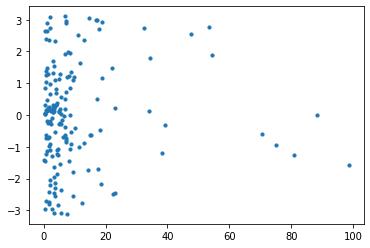

In [33]:
plt.scatter(R,phi,s=10)

In [11]:
# store all data it into one huge array
rec = np.recarray(len(data['Cluster']), dtype=[('name',object),
                                      ('X', float),
                                      ('Y', float),
                                      ('Z', float),
                                      ('vx', float),
                                      ('vy', float),
                                      ('vz', float),
                                      ('Rgal', float),
                                      ('phi', float),
                                      ('Zgal', float),
                                      ('vR', float),
                                      ('vT', float), #here U==vR, V==vT, W==vZ
                                      ('vZ', float)])

rec['name'] = data['Cluster']
rec['X'] = XYZ[:,0]
rec['Y'] = XYZ[:,1]
rec['Z'] = XYZ[:,2]
rec['vx'] = vxyz[:,0]
rec['vy'] = vxyz[:,1]
rec['vz'] = vxyz[:,2]
rec['Rgal'] = Rpz[:,0]
rec['phi'] = Rpz[:,1]
rec['Zgal'] = Rpz[:,2]
rec['vR'] = vRvTvz[:,0]
rec['vT'] = vRvTvz[:,1]
rec['vZ'] = vRvTvz[:,2]

# savepath = 'some_directory'
# filename = 'some_file_name'

# np.savetxt(savepath+filename+'.txt',rec,delimiter=',', header = 'Name,X,Y,Z,vx,vy,vz,Rgal,phi,Zgal,vR,vT,vZ',fmt='%s,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f', comments='')
